In [80]:
"""
Train a deep learning model on facial emotion detection
Dataset from: https://www.kaggle.com/msambare/fer2013
"""


'\nTrain a deep learning model on facial emotion detection\nDataset from: https://www.kaggle.com/msambare/fer2013\n'

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


2022-05-04 00:32:17.067465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 00:32:17.067488: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data overview

In [2]:
data = pd.read_csv('fer2013.csv')
data.shape


(35887, 3)

In [3]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data.Usage.value_counts()


Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


In [6]:
#sns.set_style("darkgrid")

plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

NameError: name 'sns' is not defined

<Figure size 432x288 with 0 Axes>

In [6]:
data["emotion"].value_counts().sort_index()

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64

### View some images

In [17]:
len(data)

35887

/tmp/ipykernel_52818/2074511377.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([image.astype(np.uint8), emotion])


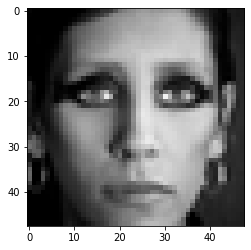

In [16]:
face = data[data['emotion'] == 7-1].iloc[0]
img = row2image(face)
plt.imshow(img[0])

/tmp/ipykernel_52818/2723053721.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([image.astype(np.uint8), emotion])
/tmp/ipykernel_52818/2723053721.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([image.astype(np.uint8), emotion])
/tmp/ipykernel_52818/2723053721.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

/tmp/ipykernel_52818/2723053721.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([image.astype(np.uint8), emotion])
/tmp/ipykernel_52818/2723053721.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([image.astype(np.uint8), emotion])
/tmp/ipykernel_52818/2723053721.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

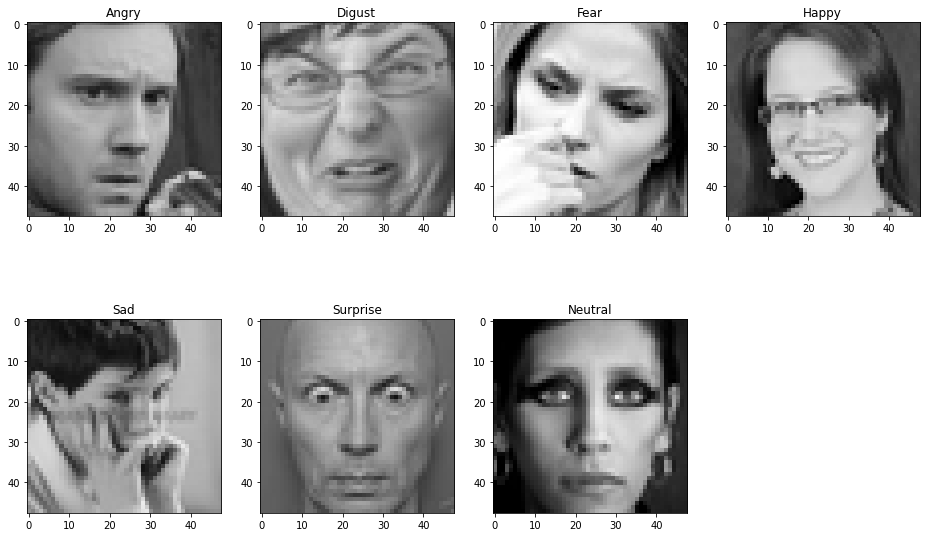

In [21]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for j in range(10):
    for i in range(1,8):
        face = data[data['emotion'] == i-1].iloc[0]
        img = row2image(face)
        plt.subplot(2,4,i)
        plt.imshow(img[0])
        plt.title(img[1])

plt.show()  

### Data preprocessing


In [23]:
7178/len(data)

0.20001671914620894

In [ ]:
"""
Summary:
    - Splitting dataset into 3 parts: train, validation, test
    - Convert strings to lists of integers
    - Reshape to 48x48 and normalise grayscale image with 255.0
    - Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]
"""

In [97]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


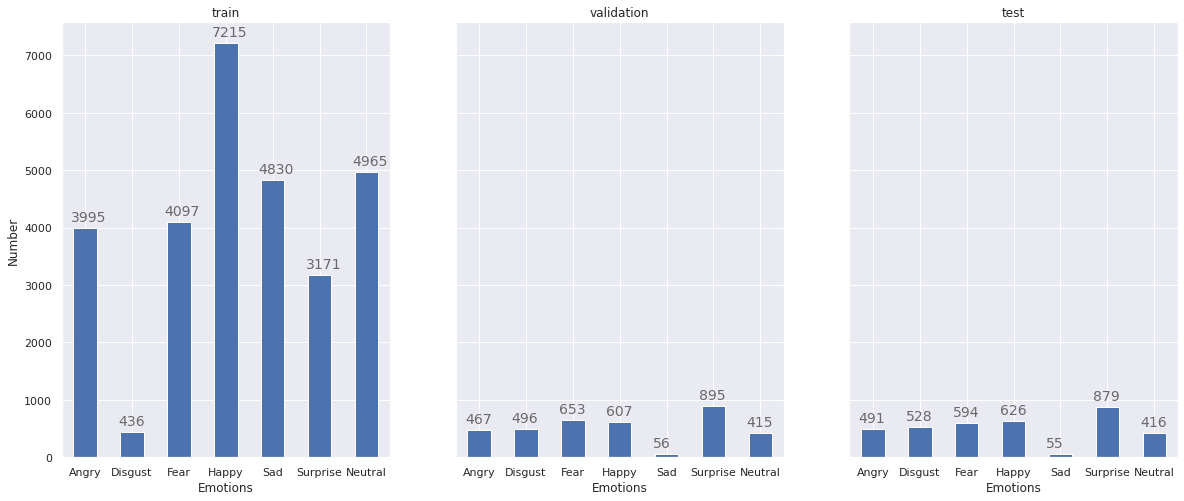

In [98]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [99]:
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64


In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [102]:
df = data_train
df['pixels'] = df['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])


In [103]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]


def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

test_X, test_Y   = CRNO(data_test, "test") #test data

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


AttributeError: 'list' object has no attribute 'split'

In [ ]:
"""Building CNN Model
CNN Architecture:¶
Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
Flatten
Dense -> BN -> Activation
Dense -> BN -> Activation
Dense -> BN -> Activation
Output layer
"""

In [62]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

2022-05-02 16:08:15.189248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 16:08:15.189280: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 16:08:15.189312: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Djoudja): /proc/driver/nvidia/version does not exist
2022-05-02 16:08:15.189657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'BatchNormalization' is not defined

In [26]:
image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
)    

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory=train_data_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory=validation_data_dir,
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                 )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [35]:
emotion_map = training_set.class_indices

In [36]:
emotion_map

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
data = pd.read_csv('../input/fer2013.csv')
#check data shape
data.shape

## KAGGLE 

In [105]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2
image_generator = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=2, 
    vertical_flip=2
)    

training_set = image_generator.flow_from_directory(batch_size=256,
                                                 directory='data/train',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                  color_mode = "grayscale"
                                                )

testing_set = image_generator.flow_from_directory(batch_size=128,
                                                 directory='data/test',
                                                 shuffle=True,
                                                 target_size=(48, 48), 
                                                 class_mode='categorical',
#                                                color_mode = "grayscale"
                                                 )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [106]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [107]:
model = VGG19(
      input_shape = (48, 48, 3),
      include_top = False,
      weights = 'imagenet'
    )

In [108]:
for layers in model.layers:
    layers.trainable = False

In [109]:
x = Flatten()(model.output)
x = Dense(512, activation = "relu")(x)
x = Dropout(0.5)(x)
x = Dense(14, activation = "relu")(x)
x = Dense(7, activation = "softmax")(x)

model = keras.Model(model.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [112]:
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 5)


/home/ferroudja/.local/lib/python3.8/site-packages/keras/engine/training.py:1977: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-03 09:19:11.572916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-05-03 09:19:12.257315: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.
2022-05-03 09:19:12.356781: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.


  1/113 [..............................] - ETA: 5:10 - loss: 2.0974 - accuracy: 0.1250

2022-05-03 09:19:14.421785: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.
2022-05-03 09:19:14.492931: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.


  2/113 [..............................] - ETA: 3:50 - loss: 2.0107 - accuracy: 0.1426

2022-05-03 09:19:16.494695: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 150994944 exceeds 10% of free system memory.


113/113 [==============================] - 378s 3s/step - loss: 1.7609 - accuracy: 0.2865 - val_loss: 1.6601 - val_accuracy: 0.3551
Epoch 2/5
113/113 [==============================] - 296s 3s/step - loss: 1.6693 - accuracy: 0.3412 - val_loss: 1.6254 - val_accuracy: 0.3653
Epoch 3/5
113/113 [==============================] - 306s 3s/step - loss: 1.6378 - accuracy: 0.3530 - val_loss: 1.6126 - val_accuracy: 0.3682
Epoch 4/5
113/113 [==============================] - 303s 3s/step - loss: 1.6248 - accuracy: 0.3600 - val_loss: 1.5951 - val_accuracy: 0.3763
Epoch 5/5
113/113 [==============================] - 316s 3s/step - loss: 1.6133 - accuracy: 0.3640 - val_loss: 1.5891 - val_accuracy: 0.3771


In [113]:
hist = hist.history

Text(0, 0.5, 'accuracy')

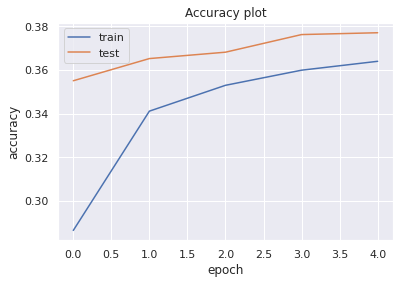

In [114]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

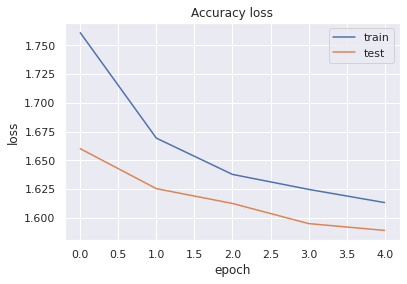

In [116]:
plt.savefig("CNNv2_accuracy.png")

plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("CNNv2_loss.png")
model.save("CNNv2.h5")

In [117]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        'data/train',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
#         color_mode="grayscale",
        class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [118]:
dim = (48,48) # for MobileNetV2
n_sequence = 8 # for LSTM
n_channels = 3 # color channel(RGB)
n_output = 7 #18 # number of output class
model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(24, activation='relu'))
model.add(Dropout(.5))  
model.add(Dense(n_output, activation='softmax'))

# model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# opt = Adam(lr=0.0001)
model.compile(optimizer = "adam",loss = "categorical_crossentropy" , metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# hist = model.fit_generator(train_generator, validation_data = validation_generator , epochs = 20)
hist = model.fit_generator(training_set, validation_data = testing_set , epochs = 25)

9420800/9406464 [==============================] - 7s 1us/step
Epoch 1/25


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential_1/cu_dnnlstm/CudnnRNNV2}} with these attrs: [seed=0, dropout=0, input_mode="linear_input", T=DT_FLOAT, direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]

	 [[sequential_1/cu_dnnlstm/CudnnRNNV2]] [Op:__inference_train_function_17872]

In [ ]:
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv2_accuracy.png")

plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv2_loss.png")

In [ ]:




model.save("mobilenetCuDNNLSTMv2.h5")
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

cv2.ocl.setUseOpenCL(False)

emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

# save trained model weight in .h5 file
emotion_model.save('emotion_model.h5')
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")

hist = emotion_model_info.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("emotion_model_accuracy.png")

plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("emotion_model_loss.png")

model = Sequential()    
model.add(tf.keras.layers.Reshape((1, 48, 48, 3), input_shape=(48, 48, 3)))
model.add( 
    TimeDistributed(
        MobileNetV2(weights='imagenet',include_top=False), 
        input_shape=(n_sequence, *dim, n_channels)
    )
)
model.add(
    TimeDistributed(
        GlobalAveragePooling2D()
    )
)
model.add(CuDNNLSTM(128,return_sequences = True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(128))
model.add(Dropout(0.2))

model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(7,activation = 'softmax'))

cv2.ocl.setUseOpenCL(False)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

# Train the neural network/model
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

hist = hist.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.savefig("mobilenetCuDNNLSTMv4_accuracy.png")

plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig("mobilenetCuDNNLSTMv4_loss.png")

model.save("mobilenetCuDNNLSTMv4.h5")

In [120]:
import cv2
cap = cv2.VideoCapture(0)
cap2 = cv2.VideoCapture(0)
while True:

    ret, frame = cap.read()
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@19418.214] global /io/opencv/modules/videoio/src/cap_v4l.cpp (889) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ WARN:0@19418.215] global /io/opencv/modules/videoio/src/cap_v4l.cpp (889) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


error: OpenCV(4.5.5) /io/opencv/modules/highgui/src/window.cpp:1000: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [ ]:
cap = cv2.VideoCapture(0)
while True:
        # Find haar cascade to draw bounding box around face
        ret, frame = cap.read()
        facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

[ WARN:0@19678.395] global /io/opencv/modules/videoio/src/cap_v4l.cpp (889) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
